<a href="https://colab.research.google.com/github/lottle2008/MOOCCube-Transformer-Recommendation/blob/main/lun_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================
# 🚀 MOOCCube / Lun Project Unified Notebook
# Author: jason
# Description: Full pipeline for HIN + GCN + SASRec
# Compatible: Google Colab (GPU)
# ==============================================

# ====== 0️⃣ 环境配置与基础依赖 ======
!pip install --upgrade pip
!pip install pandas numpy tqdm matplotlib seaborn scipy scikit-learn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!pip install torch-geometric

import os, random, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

# ====== 路径设置 ======
PROJECT_ROOT = "/content/drive/MyDrive/lun"
RAW_DIR = f"{PROJECT_ROOT}/data3"   # 原始数据
DATA_DIR = f"{PROJECT_ROOT}/data"   # 清洗后数据
os.makedirs(DATA_DIR, exist_ok=True)

# ====== 随机种子与设备 ======
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", DEVICE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s  0:00:00
Mounted at /content/drive
✅ Using device: cuda


In [2]:

# ==============================================
# 1️⃣ 数据准备阶段
# ==============================================
print("\n=== [Stage 1] 数据准备与清洗 ===")

expected_files = ["users.csv", "videos.csv", "concepts.csv", "watch_logs.csv"]
existing = [f for f in expected_files if os.path.exists(os.path.join(DATA_DIR, f))]

if len(existing) == 4:
    print("✅ 已存在数据文件，跳过生成阶段。")
else:
    print("⚠️ 未找到数据文件，生成小样本测试集...")
    users = pd.DataFrame({"user_id": [f"u{i}" for i in range(1, 51)]})
    concepts = pd.DataFrame({"concept_id": [f"c{i}" for i in range(1, 31)],
                             "concept_name":[f"concept_{i}" for i in range(1,31)]})
    videos = []
    logs = []
    for vid in range(1, 101):
        vid_id = f"v{vid}"
        cons = random.sample(list(concepts.concept_id), k=random.choice([1,2,3]))
        videos.append({
            "video_id": vid_id,
            "title": f"Video {vid}",
            "duration": random.choice([300,600,900]),
            "concept_ids": ",".join(cons)
        })
    for user in users.user_id:
        watched = random.sample([v["video_id"] for v in videos], k=random.randint(5,20))
        for v in watched:
            dur = next(item for item in videos if item["video_id"]==v)["duration"]
            wt = int(dur * random.uniform(0.1,1.0))
            comp = wt / dur
            speed = random.choice([1.0,1.25,1.5])
            logs.append({
                "user_id": user,
                "video_id": v,
                "watch_time": wt,
                "video_duration": dur,
                "completion_rate": comp,
                "avg_playback_speed": speed
            })
    videos = pd.DataFrame(videos)
    logs = pd.DataFrame(logs)
    users.to_csv(os.path.join(DATA_DIR,"users.csv"), index=False)
    videos.to_csv(os.path.join(DATA_DIR,"videos.csv"), index=False)
    concepts.to_csv(os.path.join(DATA_DIR,"concepts.csv"), index=False)
    logs.to_csv(os.path.join(DATA_DIR,"watch_logs.csv"), index=False)
    print("✅ Demo data generated and saved.")

# ====== 加载数据 ======
users_df = pd.read_csv(os.path.join(DATA_DIR,"users.csv"))
videos_df = pd.read_csv(os.path.join(DATA_DIR,"videos.csv"))
concepts_df = pd.read_csv(os.path.join(DATA_DIR,"concepts.csv"))
logs_df = pd.read_csv(os.path.join(DATA_DIR,"watch_logs.csv"))

# ====== 特征计算 ======
user_stats = logs_df.groupby("user_id").agg(
    avg_speed=("avg_playback_speed","mean"),
    avg_completion=("completion_rate","mean"),
    total_watch_time=("watch_time","sum"),
    total_videos=("video_id","count")
).reset_index()

video_stats = logs_df.groupby("video_id").agg(
    avg_completion=("completion_rate","mean"),
    avg_watch_time=("watch_time","mean"),
    total_views=("user_id","count")
).reset_index()

# ====== 合并前清理，防止重复列冲突 ======
def safe_merge(base_df, add_df, key):
    # 删除冲突列
    conflict_cols = list(set(base_df.columns) & set(add_df.columns) - {key})
    if conflict_cols:
        print(f"⚠️ 检测到冲突列，已删除: {conflict_cols}")
        base_df = base_df.drop(columns=conflict_cols, errors='ignore')
    return base_df.merge(add_df, on=key, how="left").fillna(0)

users_df = safe_merge(users_df, user_stats, "user_id")
videos_df = safe_merge(videos_df, video_stats, "video_id")


"""
# 删除旧列防止冲突并合并
conflict_cols = set(users_df.columns) & set(user_stats.columns) - {"user_id"}
if conflict_cols:
    users_df = users_df.drop(columns=list(conflict_cols), errors='ignore')
users_df = users_df.merge(user_stats, on="user_id", how="left").fillna(0)
videos_df = videos_df.merge(video_stats, on="video_id", how="left").fillna(0)
"""
# 生成视频-概念映射
video_concept_edges = []
for _, row in videos_df.iterrows():
    c_list = [c.strip() for c in str(row["concept_ids"]).split(",") if c.strip()]
    for c in c_list:
        video_concept_edges.append({"video_id": row["video_id"], "concept_id": c})
edges_df = pd.DataFrame(video_concept_edges)
edges_df.to_csv(os.path.join(DATA_DIR, "video_concept_edges.csv"), index=False)

users_df.to_csv(os.path.join(DATA_DIR,"users.csv"), index=False)
videos_df.to_csv(os.path.join(DATA_DIR,"videos.csv"), index=False)
print("✅ 数据准备完成，路径:", DATA_DIR)


=== [Stage 1] 数据准备与清洗 ===
✅ 已存在数据文件，跳过生成阶段。
⚠️ 检测到冲突列，已删除: ['avg_completion', 'total_videos', 'avg_speed', 'total_watch_time']
⚠️ 检测到冲突列，已删除: ['avg_completion', 'total_views', 'avg_watch_time']
✅ 数据准备完成，路径: /content/drive/MyDrive/lun/data


In [3]:

# ==============================================
# 2️⃣ 异构图 HIN + GCN 训练阶段
# ==============================================
print("\n=== [Stage 2] HIN + GCN 训练 ===")

from torch_geometric.nn import GCNConv
from scipy.sparse import coo_matrix

# 读取数据
users_df = pd.read_csv(os.path.join(DATA_DIR,"users.csv"))
videos_df = pd.read_csv(os.path.join(DATA_DIR,"videos.csv"))
concepts_df = pd.read_csv(os.path.join(DATA_DIR,"concepts.csv"))
logs_df = pd.read_csv(os.path.join(DATA_DIR,"watch_logs.csv"))
edges_df = pd.read_csv(os.path.join(DATA_DIR,"video_concept_edges.csv"))

# 建立索引
user2idx = {u: i for i, u in enumerate(users_df["user_id"].unique())}
video2idx = {v: i for i, v in enumerate(videos_df["video_id"].unique())}
concept2idx = {c: i for i, c in enumerate(concepts_df["concept_id"].unique())}

num_users, num_videos, num_concepts = len(user2idx), len(video2idx), len(concept2idx)
print(f"Nodes: User={num_users}, Video={num_videos}, Concept={num_concepts}")


# ====== 建立边（用户-视频、视频-概念）并做安全映射 ======
print("\n🔧 开始构建异构图索引...")

uv_edges = logs_df[["user_id", "video_id"]].drop_duplicates().copy()
vc_edges = edges_df[["video_id", "concept_id"]].drop_duplicates().copy()

# 检查映射前数据
print(f"uv_edges: {len(uv_edges)} | vc_edges: {len(vc_edges)}")

# 做安全映射，丢弃无效映射
uv_edges["u_idx"] = uv_edges["user_id"].map(user2idx)
uv_edges["v_idx"] = uv_edges["video_id"].map(video2idx)
uv_edges = uv_edges.dropna(subset=["u_idx", "v_idx"])

vc_edges["v_idx"] = vc_edges["video_id"].map(video2idx)
vc_edges["c_idx"] = vc_edges["concept_id"].map(concept2idx)
vc_edges = vc_edges.dropna(subset=["v_idx", "c_idx"])

# 转换为整数索引
uv_src = uv_edges["u_idx"].astype(int)
uv_dst = uv_edges["v_idx"].astype(int) + num_users

vc_src = vc_edges["v_idx"].astype(int) + num_users
vc_dst = vc_edges["c_idx"].astype(int) + num_users + num_videos

print(f"有效边数量: U-V={len(uv_src)}, V-C={len(vc_src)}")


=== [Stage 2] HIN + GCN 训练 ===
Nodes: User=31885, Video=34884, Concept=71627

🔧 开始构建异构图索引...
uv_edges: 58523 | vc_edges: 34885
有效边数量: U-V=58523, V-C=575


In [4]:

# ====== 构建稀疏邻接矩阵 ======
row = np.concatenate([uv_src, vc_src])
col = np.concatenate([uv_dst, vc_dst])
data = np.ones(len(row))

total_nodes = num_users + num_videos + num_concepts
if len(row) == 0:
    raise RuntimeError("⚠️ 无有效边，检查ID映射或源数据格式。")

adj = coo_matrix((data, (row, col)), shape=(total_nodes, total_nodes))

# 假设 adj 是 CSR 格式
adj = adj + adj.T  # 对称化
adj = adj.tocoo()  # ✅ 转换为 COO 格式

edge_index = torch.tensor(np.vstack([adj.row, adj.col]), dtype=torch.long)
print("✅ 图结构构建成功，edge_index:", edge_index.shape)


edge_index = torch.tensor(np.vstack([adj.row, adj.col]), dtype=torch.long)
print("✅ 图结构构建成功，edge_index:", edge_index.shape)

✅ 图结构构建成功，edge_index: torch.Size([2, 118196])
✅ 图结构构建成功，edge_index: torch.Size([2, 118196])


In [5]:
# ====== 定义简单GCN ======
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_feats, hidden, out_feats):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden)
        self.conv2 = GCNConv(hidden, out_feats)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


# ====== 训练 ======
num_nodes = num_users + num_videos + num_concepts
feature_dim = 64  # 节点特征维度，可自行调整
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ 用嵌入层生成可训练节点特征，替代 torch.eye()
embedding_layer = torch.nn.Embedding(num_nodes, feature_dim).to(DEVICE)
features = embedding_layer.weight  # shape: [num_nodes, feature_dim]

# 定义模型
model = SimpleGCN(in_feats=feature_dim, hidden=64, out_feats=32).to(DEVICE)
optimizer = torch.optim.Adam(list(model.parameters()) + list(embedding_layer.parameters()), lr=0.01)
model.train()

for epoch in range(10):
    optimizer.zero_grad()
    out = model(features, edge_index.to(DEVICE))
    loss = torch.mean(out ** 2)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/10 | Loss: {loss.item():.4f}")


# ====== 保存嵌入 ======
embeddings = out.detach().cpu().numpy()
user_embs = embeddings[:num_users]
concept_embs = embeddings[num_users + num_videos:]
np.save(os.path.join(DATA_DIR, "user_embs.npy"), user_embs)
np.save(os.path.join(DATA_DIR, "concept_embs.npy"), concept_embs)
print("✅ 嵌入保存完成: user_embs.npy, concept_embs.npy")


Epoch 1/10 | Loss: 0.4148
Epoch 2/10 | Loss: 0.2627
Epoch 3/10 | Loss: 0.1897
Epoch 4/10 | Loss: 0.1446
Epoch 5/10 | Loss: 0.1105
Epoch 6/10 | Loss: 0.0837
Epoch 7/10 | Loss: 0.0634
Epoch 8/10 | Loss: 0.0485
Epoch 9/10 | Loss: 0.0381
Epoch 10/10 | Loss: 0.0309
✅ 嵌入保存完成: user_embs.npy, concept_embs.npy


In [6]:

# ==============================================
# 3️⃣ SASRec 推荐阶段（简化演示）
# ==============================================
print("\n=== [Stage 3] 序列推荐（SASRec简化版）===")

# 生成用户行为序列
seq_data = logs_df.groupby("user_id")["video_id"].apply(list).to_dict()
print(f"Total sequences: {len(seq_data)} users")

# （此处仅示例展示，完整SASRec训练可扩展至Week 9 Notebook）
print("✅ 数据流水线构建完成。下一步可在独立 Notebook 进行推荐模型训练与融合策略。")

# ==============================================
print("\n🎉 全流程完成：数据准备 → 图训练 → 序列构建 ✅")
print("输出文件目录:", DATA_DIR)



=== [Stage 3] 序列推荐（SASRec简化版）===
Total sequences: 31863 users
✅ 数据流水线构建完成。下一步可在独立 Notebook 进行推荐模型训练与融合策略。

🎉 全流程完成：数据准备 → 图训练 → 序列构建 ✅
输出文件目录: /content/drive/MyDrive/lun/data


In [7]:
# ==========================
# Stage 3: SASRec-style recommendation + GCN fusion
# Colab-ready (paste & run)
# ==========================

import os, random, math, time
import numpy as np, pandas as pd
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# --------------------------
# Config / paths
# --------------------------
PROJECT_ROOT = "/content/drive/MyDrive/lun"
DATA_DIR = os.path.join(PROJECT_ROOT, "data")

VIDEOS_CSV = os.path.join(DATA_DIR, "videos.csv")
LOGS_CSV = os.path.join(DATA_DIR, "watch_logs.csv")
VIDEO_CONCEPT_CSV = os.path.join(DATA_DIR, "video_concept_edges.csv")
USER_EMB_NPY = os.path.join(DATA_DIR, "user_embs.npy")
CONCEPT_EMB_NPY = os.path.join(DATA_DIR, "concept_embs.npy")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# --------------------------
# Hyperparameters (tuneable)
# --------------------------
SEQ_LEN = 50                 # max length of user behavior sequence
ITEM_EMB_DIM = 64            # item embedding dim used by SASRec
MODEL_DIM = 64               # transformer hidden dim
NUM_HEADS = 4
NUM_LAYERS = 2
DROPOUT = 0.1

BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 6
NEG_SAMPLES = 1              # negative samples per positive for training
EVAL_KS = [5, 10]

# Fusion setting: "none", "concat", "add"
FUSION = "concat"

# --------------------------
# Load files
# --------------------------
videos_df = pd.read_csv(VIDEOS_CSV)
logs_df = pd.read_csv(LOGS_CSV)
if os.path.exists(VIDEO_CONCEPT_CSV):
    v2c_df = pd.read_csv(VIDEO_CONCEPT_CSV)
else:
    v2c_df = pd.DataFrame(columns=["video_id","concept_id"])

user_embs = np.load(USER_EMB_NPY) if os.path.exists(USER_EMB_NPY) else None
concept_embs = np.load(CONCEPT_EMB_NPY) if os.path.exists(CONCEPT_EMB_NPY) else None

# map ids to contiguous indexes
video_ids = videos_df["video_id"].astype(str).unique().tolist()
video2idx = {v: i for i, v in enumerate(video_ids)}
idx2video = {i:v for v,i in video2idx.items()}
num_items = len(video_ids)
print(f"num_items: {num_items}")

# ensure logs reference strings
logs_df["video_id"] = logs_df["video_id"].astype(str)
logs_df["user_id"] = logs_df["user_id"].astype(str)

# build user sequences sorted by appearance order (assume logs are chronological or use a timestamp if available)
# if watch_logs has time column, sort by it; else rely on file order
time_col = None
for candidate in ["timestamp", "time", "created_at", "watch_time"]:  # watch_time is duration, not time; we skip
    if candidate in logs_df.columns:
        time_col = candidate
        break

if time_col:
    logs_df = logs_df.sort_values(time_col)
else:
    logs_df = logs_df.copy()  # keep current order

user_hist = logs_df.groupby("user_id")["video_id"].apply(list).to_dict()
print("Total users with sequences:", len(user_hist))

# --------------------------
# Build train/valid/test splits (leave-one-out)
# --------------------------
train_seqs, val_seqs, test_seqs = dict(), dict(), dict()
all_users = list(user_hist.keys())
for u, seq in user_hist.items():
    if len(seq) < 2:
        # ignore too-short sequences for eval; keep for training if needed
        train_seqs[u] = seq
        continue
    train_seqs[u] = seq[:-2] if len(seq) >= 3 else seq[:-1]
    val_seqs[u] = seq[-2] if len(seq) >= 2 else None
    test_seqs[u] = seq[-1]

# Build item to concepts mapping (for fusion init)
video2concepts = v2c_df.groupby("video_id")["concept_id"].apply(list).to_dict()

# --------------------------
# Build initial item embeddings from concept embeddings (if available)
# --------------------------
if concept_embs is not None and len(concept_embs)>0:
    # concept_embs is array of shape [num_concepts, c_dim]
    # we must map concept ids to indices; assume concepts file ordering corresponds to concept_embs index from Stage 2
    # If concept ids in v2c_df are strings like 'c1', we attempt to parse index; fallback: random init
    c_emb = concept_embs
    c_dim = c_emb.shape[1]
    # Build a function to get mean concept embedding for a video
    def video_concept_mean(video_id):
        concepts = video2concepts.get(video_id, [])
        if len(concepts) == 0:
            return None
        # try to parse concept id to index: if 'cX' -> index X-1
        vecs = []
        for c in concepts:
            try:
                if isinstance(c, str) and c.startswith("c"):
                    idx = int(c[1:]) - 1
                else:
                    idx = int(c)  # try cast
                if 0 <= idx < len(c_emb):
                    vecs.append(c_emb[idx])
            except Exception:
                pass
        if len(vecs)==0:
            return None
        return np.mean(vecs, axis=0)
else:
    c_emb = None
    c_dim = 0
    def video_concept_mean(video_id):
        return None

# Construct initial numpy item_emb_init: for each video index, try concept mean, else random
item_emb_init = np.random.normal(0, 0.01, size=(num_items, ITEM_EMB_DIM)).astype(np.float32)
for v, idx in video2idx.items():
    vm = video_concept_mean(v)
    if vm is not None:
        # project or pad vm to ITEM_EMB_DIM
        vm = np.asarray(vm, dtype=np.float32)
        if vm.shape[0] == ITEM_EMB_DIM:
            item_emb_init[idx] = vm
        elif vm.shape[0] < ITEM_EMB_DIM:
            # pad
            pad = np.zeros(ITEM_EMB_DIM - vm.shape[0], dtype=np.float32)
            item_emb_init[idx] = np.concatenate([vm, pad])
        else:
            # truncate or project; simple truncate
            item_emb_init[idx] = vm[:ITEM_EMB_DIM]

# --------------------------
# Dataset for training (SLiding with negative sampling)
# --------------------------
class SeqDataset(Dataset):
    def __init__(self, train_seqs, video2idx, seq_len=SEQ_LEN, neg_samples=NEG_SAMPLES):
        self.users = list(train_seqs.keys())
        self.train_seqs = train_seqs
        self.video2idx = video2idx
        self.seq_len = seq_len
        self.neg_samples = neg_samples
        self.num_items = len(video2idx)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        u = self.users[idx]
        seq = [self.video2idx[x] for x in self.train_seqs[u] if x in self.video2idx]
        if len(seq) == 0:
            seq = [random.randrange(self.num_items)]
        # pad or trim to seq_len (we use right-aligned: last items are most recent)
        seq = seq[-self.seq_len:]
        padded = [0] * (self.seq_len - len(seq)) + seq
        target = seq[-1]  # we will treat last as positive, but for SASRec we normally create many training pairs; simplified here
        # sample negatives
        negs = [random.randrange(self.num_items) for _ in range(self.neg_samples)]
        return torch.tensor(padded, dtype=torch.long), torch.tensor(target, dtype=torch.long), torch.tensor(negs, dtype=torch.long), u

# dataloader
train_dataset = SeqDataset(train_seqs, video2idx, seq_len=SEQ_LEN, neg_samples=NEG_SAMPLES)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2)

# --------------------------
# SASRec-like model (simplified)
# --------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # 1 x max_len x d_model

    def forward(self, x):
        # x shape: (B, L, D)
        L = x.size(1)
        return x + self.pe[:, -L:, :]

class SASRecLite(nn.Module):
    def __init__(self, num_items, item_emb_dim, model_dim, num_layers=2, num_heads=4, dropout=0.1, fusion="none", gcn_item_dim=None):
        super().__init__()
        self.item_embedding = nn.Embedding(num_items, item_emb_dim)
        self.pos_enc = PositionalEncoding(model_dim, max_len=SEQ_LEN)
        # if fusion concat, we will expand input dim
        if fusion == "concat":
            input_dim = item_emb_dim + (gcn_item_dim or 0)
            # project to model_dim
            self.input_projection = nn.Linear(input_dim, model_dim)
        else:
            # if add, ensure item_emb_dim == gcn_item_dim and project to model_dim
            input_dim = item_emb_dim
            self.input_projection = nn.Linear(input_dim, model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fusion = fusion

        # final prediction: dot product between seq output (last position) and candidate item embeddings (projected to model_dim)
        self.output_layer = nn.Linear(model_dim, model_dim)  # optional projection

    def forward(self, seq_items, item_gcn_emb=None):
        """
        seq_items: (B, L) item indices
        item_gcn_emb: (num_items, gcn_dim) or None
        """
        item_emb = self.item_embedding(seq_items)  # B x L x item_emb_dim

        if self.fusion == "none" or item_gcn_emb is None:
            x = self.input_projection(item_emb)  # B x L x model_dim
        elif self.fusion == "add":
            # get gcn emb for sequence items and add (requires same dim)
            g_emb = F.embedding(seq_items, item_gcn_emb)  # B x L x gcn_dim
            # if dims differ, project g_emb to item_emb dim (handled outside ideally)
            x = self.input_projection(item_emb + g_emb)
        elif self.fusion == "concat":
            g_emb = F.embedding(seq_items, item_gcn_emb)  # B x L x gcn_dim
            cat = torch.cat([item_emb, g_emb], dim=-1)
            x = self.input_projection(cat)  # B x L x model_dim
        else:
            raise ValueError("Unknown fusion")

        x = self.pos_enc(x)
        x = self.transformer(x)  # B x L x model_dim
        x = self.dropout(x)
        # take last position representation (most recent)
        seq_repr = x[:, -1, :]  # B x model_dim
        logits = self.output_layer(seq_repr)  # B x model_dim
        return logits  # we'll use dot product with item embeddings during loss/eval

# --------------------------
# Prepare model and load initial item embeddings
# --------------------------
# model requires item embedding to be in item_emb_dim; we have item_emb_init numpy
item_emb_init_torch = torch.tensor(item_emb_init)  # num_items x ITEM_EMB_DIM

# if fusion uses GCN item vector, build item_gcn_emb (project concept-derived embedding to some gcn_item_dim)
# We'll set gcn_item_dim = ITEM_EMB_DIM for simplicity (so concat becomes ITEM_EMB_DIM + ITEM_EMB_DIM)
gcn_item_dim = ITEM_EMB_DIM
item_gcn_emb = item_emb_init_torch.clone()  # using same init as "GCN" proxy; if actual GCN item embeddings exist, replace here

# Build model
model = SASRecLite(num_items=num_items, item_emb_dim=ITEM_EMB_DIM, model_dim=MODEL_DIM,
                   num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT,
                   fusion=FUSION, gcn_item_dim=gcn_item_dim).to(DEVICE)

# initialize model's item_embedding with item_emb_init
with torch.no_grad():
    model.item_embedding.weight.copy_(item_emb_init_torch.to(DEVICE))

# if fusion == "concat" we want item_gcn_emb on GPU and sized correctly
item_gcn_emb = item_gcn_emb.to(DEVICE)

# optimizer: include embedding weights
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss(reduction="none")

# --------------------------
# Helper: evaluate (Recall@K, NDCG@K) using leave-one-out test
# --------------------------
def evaluate_model(model, test_seqs, train_seqs, video2idx, K_list=[5,10], device=DEVICE, item_gcn_emb=None):
    model.eval()
    hits = {k: 0 for k in K_list}
    ndcgs = {k: 0.0 for k in K_list}
    user_cnt = 0
    with torch.no_grad():
        for u, test_item in test_seqs.items():
            # construct input sequence = train_seqs[u] (all except last)
            seq = [video2idx[x] for x in train_seqs.get(u, []) if x in video2idx]
            if len(seq) == 0:
                seq = [0]  # fallback
            seq = seq[-SEQ_LEN:]
            padded = [0] * (SEQ_LEN - len(seq)) + seq
            seq_tensor = torch.tensor([padded], dtype=torch.long).to(device)  # 1 x L
            logits = model(seq_tensor, item_gcn_emb)  # 1 x model_dim
            # compute scores as dot product between logits and all candidate items (project item embedding to model dim)
            # project item embeddings: use model.item_embedding -> get item vectors and project to model_dim via model.input_projection if needed
            # Simpler: get item embedding and project via same pipeline: item_emb -> input_projection -> transformer (skip) -> output_layer?
            # For ranking, compute similarity between logits and item_embedding projected to model_dim using model.output_layer weight/param
            all_item_emb = model.item_embedding.weight  # num_items x item_emb_dim
            # if fusion concat and item_gcn_emb exists, we must produce the same projected representation as used for seq items:
            if FUSION == "none":
                it_proj = model.input_projection(all_item_emb)  # num_items x model_dim
            elif FUSION == "add":
                # add item_gcn_emb and then project
                it_proj = model.input_projection(all_item_emb + item_gcn_emb)
            elif FUSION == "concat":
                cat = torch.cat([all_item_emb, item_gcn_emb], dim=-1)
                it_proj = model.input_projection(cat)
            else:
                it_proj = model.input_projection(all_item_emb)
            # compute scores
            scores = torch.matmul(it_proj, logits.squeeze(0).t()).squeeze(-1)  # num_items
            scores = scores.cpu().numpy()
            # filter: exclude items present in train_seqs[u] to mimic ranking among unseen (optional)
            train_set = set([video2idx[x] for x in train_seqs.get(u, []) if x in video2idx])
            # set seen items to -inf
            scores[list(train_set)] = -1e9
            # get top-K
            ranking = np.argsort(-scores)
            user_cnt += 1
            # ground truth index
            if test_item not in video2idx:
                continue
            gt = video2idx[test_item]
            for K in K_list:
                topk = ranking[:K]
                if gt in topk:
                    hits[K] += 1
                    # compute ndcg contribution
                    rank_pos = np.where(topk == gt)[0][0]
                    ndcgs[K] += 1.0 / np.log2(rank_pos + 2)
    # finalize
    res = {}
    for K in K_list:
        res[f"Recall@{K}"] = hits[K] / user_cnt if user_cnt>0 else 0.0
        res[f"NDCG@{K}"] = ndcgs[K] / user_cnt if user_cnt>0 else 0.0
    return res


# ==========================
# Stage 3: SASRec + GCN fusion
# Full training, evaluation, embeddings & metrics save
# ==========================

import json
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_val = 0.0
metrics_list = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in pbar:
        seqs, pos_items, neg_items, users = batch
        seqs = seqs.to(DEVICE)
        pos_items = pos_items.to(DEVICE)
        neg_items = neg_items.to(DEVICE)

        optimizer.zero_grad()
        logits = model(seqs, item_gcn_emb)

        # 正样本
        pos_emb = model.item_embedding(pos_items)
        if FUSION == "none":
            pos_proj = model.input_projection(pos_emb)
        elif FUSION == "add":
            pos_proj = model.input_projection(pos_emb + F.embedding(pos_items, item_gcn_emb))
        elif FUSION == "concat":
            pos_proj = model.input_projection(torch.cat([pos_emb, F.embedding(pos_items, item_gcn_emb)], dim=-1))

        pos_scores = (pos_proj * model.output_layer(logits)).sum(dim=-1)

        # 负样本
        neg_idx = neg_items.view(-1)
        neg_emb = model.item_embedding(neg_idx).view(neg_items.size(0), neg_items.size(1), -1)
        if FUSION == "none":
            neg_proj = model.input_projection(neg_emb)
        elif FUSION == "add":
            neg_proj = model.input_projection(neg_emb + F.embedding(neg_items, item_gcn_emb))
        elif FUSION == "concat":
            neg_proj = model.input_projection(torch.cat([neg_emb, F.embedding(neg_items, item_gcn_emb)], dim=-1))

        log_expand = model.output_layer(logits).unsqueeze(1)
        neg_scores = (neg_proj * log_expand).sum(dim=-1)

        # BCE Loss
        pos_loss = F.binary_cross_entropy_with_logits(pos_scores, torch.ones_like(pos_scores), reduction="mean")
        neg_loss = F.binary_cross_entropy_with_logits(neg_scores, torch.zeros_like(neg_scores), reduction="mean")
        loss = pos_loss + neg_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'avg_loss': total_loss / (pbar.n+1)})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")

    # --------------------------
    # Validation
    # --------------------------
    val_metrics = evaluate_model(
        model,
        {u: v for u, v in test_seqs.items() if u in val_seqs and val_seqs[u] is not None},
        train_seqs,
        video2idx,
        K_list=EVAL_KS,
        device=DEVICE,
        item_gcn_emb=item_gcn_emb
    )
    print("Validation (approx):", val_metrics)

    # 保存最优模型
    if val_metrics.get("Recall@10", 0.0) > best_val:
        best_val = val_metrics["Recall@10"]
        torch.save(model.state_dict(), os.path.join(DATA_DIR, "sasrec_fused_best.pth"))
        print("Saved best model.")

# --------------------------
# Final evaluation on test set
# --------------------------
test_metrics = evaluate_model(model, test_seqs, train_seqs, video2idx, K_list=EVAL_KS, device=DEVICE, item_gcn_emb=item_gcn_emb)
print("Final Test Metrics:", test_metrics)

# --------------------------
# Save item embeddings
# --------------------------
with torch.no_grad():
    all_item_emb = model.item_embedding.weight
    if FUSION == "none":
        proj = model.input_projection(all_item_emb).cpu().numpy()
    elif FUSION == "add":
        proj = model.input_projection(all_item_emb + item_gcn_emb).cpu().numpy()
    elif FUSION == "concat":
        proj = model.input_projection(torch.cat([all_item_emb, item_gcn_emb], dim=-1)).cpu().numpy()
np.save(os.path.join(DATA_DIR, "item_model_embs.npy"), proj)
print("Saved item_model_embs.npy in", DATA_DIR)

# --------------------------
# Save metrics
# --------------------------
metrics = {
    "SASRec+GCN": test_metrics
}
with open(os.path.join(DATA_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f)
print("Saved metrics.json in", DATA_DIR)



Device: cuda
num_items: 34884
Total users with sequences: 31863


Epoch 1: 100%|██████████| 125/125 [00:01<00:00, 63.15it/s, avg_loss=1.14]


Epoch 1 average loss: 1.096328
Validation (approx): {'Recall@5': 0.03738632536207477, 'NDCG@5': np.float64(0.022559307273576096), 'Recall@10': 0.06534186594813068, 'NDCG@10': np.float64(0.031070841272665715)}
Saved best model.


Epoch 2: 100%|██████████| 125/125 [00:01<00:00, 76.80it/s, avg_loss=0.862]


Epoch 2 average loss: 0.862249
Validation (approx): {'Recall@5': 0.05700572583361401, 'NDCG@5': np.float64(0.03941328500413616), 'Recall@10': 0.08731896261367464, 'NDCG@10': np.float64(0.04901451166686836)}
Saved best model.


Epoch 3: 100%|██████████| 125/125 [00:01<00:00, 79.80it/s, avg_loss=0.74]


Epoch 3 average loss: 0.698097
Validation (approx): {'Recall@5': 0.0676995621421354, 'NDCG@5': np.float64(0.04633343570339663), 'Recall@10': 0.11375884136072752, 'NDCG@10': np.float64(0.06087313548469519)}
Saved best model.


Epoch 4: 100%|██████████| 125/125 [00:01<00:00, 74.82it/s, avg_loss=0.549]


Epoch 4 average loss: 0.514141
Validation (approx): {'Recall@5': 0.0679521724486359, 'NDCG@5': np.float64(0.04626692189800384), 'Recall@10': 0.10197036039070394, 'NDCG@10': np.float64(0.057160592733395466)}


Epoch 5: 100%|██████████| 125/125 [00:01<00:00, 78.91it/s, avg_loss=0.441]


Epoch 5 average loss: 0.419782
Validation (approx): {'Recall@5': 0.06845739306163691, 'NDCG@5': np.float64(0.04788478046550646), 'Recall@10': 0.11232738295722465, 'NDCG@10': np.float64(0.061562963242484545)}


Epoch 6: 100%|██████████| 125/125 [00:01<00:00, 77.78it/s, avg_loss=0.387]


Epoch 6 average loss: 0.368443
Validation (approx): {'Recall@5': 0.06685752778713372, 'NDCG@5': np.float64(0.04733835144520359), 'Recall@10': 0.11140114516672281, 'NDCG@10': np.float64(0.061553982163126436)}
Final Test Metrics: {'Recall@5': 0.06685752778713372, 'NDCG@5': np.float64(0.04733835144520359), 'Recall@10': 0.11140114516672281, 'NDCG@10': np.float64(0.061553982163126436)}
Saved item_model_embs.npy in /content/drive/MyDrive/lun/data
Saved metrics.json in /content/drive/MyDrive/lun/data


In [8]:
import json

# ==========================
# 全流程数据保存（Stage 1~3）
# ==========================

save_dir = DATA_DIR

# 1️⃣ 保存 Stage 1/2 的用户和概念嵌入
if 'user_embs' in globals() and user_embs is not None:
    np.save(os.path.join(save_dir, "user_embs.npy"), user_embs)
if 'concept_embs' in globals() and concept_embs is not None:
    np.save(os.path.join(save_dir, "concept_embs.npy"), concept_embs)

# 2️⃣ 保存 Stage 3 融合后的 item embeddings
if 'proj' in globals():
    np.save(os.path.join(save_dir, "item_model_embs.npy"), proj)

# 3️⃣ 保存 Stage 3 模型参数
torch.save(model.state_dict(), os.path.join(save_dir, "sasrec_fused_final.pth"))

# 4️⃣ 保存训练与测试评估指标
all_metrics = {
    "Stage3_test_metrics": test_metrics,
    "Stage3_val_metrics": val_metrics,
    "config": {
        "SEQ_LEN": SEQ_LEN,
        "ITEM_EMB_DIM": ITEM_EMB_DIM,
        "MODEL_DIM": MODEL_DIM,
        "NUM_HEADS": NUM_HEADS,
        "NUM_LAYERS": NUM_LAYERS,
        "DROPOUT": DROPOUT,
        "BATCH_SIZE": BATCH_SIZE,
        "LR": LR,
        "EPOCHS": EPOCHS,
        "NEG_SAMPLES": NEG_SAMPLES,
        "FUSION": FUSION,
        "DEVICE": str(DEVICE)
    }
}

with open(os.path.join(save_dir, "run_results_full.json"), "w") as f:
    json.dump(all_metrics, f, indent=4)

print("✅ 全流程数据已保存到", save_dir)


✅ 全流程数据已保存到 /content/drive/MyDrive/lun/data


In [9]:
# 将用户训练序列保存到 user_sequences.npy（可选）
user_sequences = []
for u, seq in train_seqs.items():
    user_sequences.append({"user_id": u, "pos_items": seq})
np.save(os.path.join(DATA_DIR, "user_sequences.npy"), user_sequences)
print("✅ user_sequences.npy 已生成")


✅ user_sequences.npy 已生成


In [14]:
import os
import numpy as np
import torch
import torch.nn as nn

# ====== 配置 ======
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/content/drive/MyDrive/lun/data"

# ====== 加载嵌入 ======
user_gcn_embs = np.load(os.path.join(DATA_DIR, "user_embs.npy"))
concept_gcn_embs = np.load(os.path.join(DATA_DIR, "concept_embs.npy"))
item_sasrec_embs = np.load(os.path.join(DATA_DIR, "item_model_embs.npy"))

num_users = user_gcn_embs.shape[0]
num_items = item_sasrec_embs.shape[0]

print(f"Loaded embeddings: {num_users} users, {num_items} items")

# 转为 torch tensor
user_gcn_embs = torch.tensor(user_gcn_embs, dtype=torch.float32).to(DEVICE)
item_sasrec_embs = torch.tensor(item_sasrec_embs, dtype=torch.float32).to(DEVICE)

# ====== 融合策略: concat ======
def fuse_embeddings(user_emb, item_emb, dim=64):
    user_proj = nn.Linear(user_emb.shape[1], dim).to(DEVICE)
    item_proj = nn.Linear(item_emb.shape[1], dim).to(DEVICE)
    fused_user = user_proj(user_emb)
    fused_item = item_proj(item_emb)
    return fused_user, fused_item

fused_user_embs, fused_item_embs = fuse_embeddings(user_gcn_embs, item_sasrec_embs)

# ====== 构建数据集 ======
from torch.utils.data import Dataset, DataLoader

class InteractionDataset(Dataset):
    def __init__(self, user_sequences, num_items):
        self.user_sequences = user_sequences
        self.num_items = num_items

    def __len__(self):
        return len(self.user_sequences)

    def __getitem__(self, idx):
        seq = self.user_sequences[idx]
        user_id = seq['user_id']
        pos_item = seq['pos_items'][-1]  # 最后一个正样本
        neg_item = np.random.choice(self.num_items)
        return (torch.tensor(user_id, dtype=torch.long),
                torch.tensor(pos_item, dtype=torch.long),
                torch.tensor(neg_item, dtype=torch.long))

# ====== 加载 user_sequences ======
user_sequences = np.load(os.path.join(DATA_DIR, "user_sequences.npy"), allow_pickle=True)
dataset = InteractionDataset(user_sequences, num_items)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print("✅ 数据集和 DataLoader 准备完成")


Loaded embeddings: 31885 users, 34884 items
✅ 数据集和 DataLoader 准备完成


In [16]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# ====== 配置 ======
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/content/drive/MyDrive/lun/data"

# ====== 加载嵌入 ======
user_gcn_embs = np.load(os.path.join(DATA_DIR, "user_embs.npy"))
concept_gcn_embs = np.load(os.path.join(DATA_DIR, "concept_embs.npy"))
item_sasrec_embs = np.load(os.path.join(DATA_DIR, "item_model_embs.npy"))

num_users = user_gcn_embs.shape[0]
num_items = item_sasrec_embs.shape[0]

print(f"Loaded embeddings: {num_users} users, {num_items} items")

# 转为 torch tensor
user_gcn_embs = torch.tensor(user_gcn_embs, dtype=torch.float32).to(DEVICE)
item_sasrec_embs = torch.tensor(item_sasrec_embs, dtype=torch.float32).to(DEVICE)

# ====== 融合策略 ======
# 方法 1: 拼接 (concat)
def fuse_embeddings(user_emb, item_emb):
    # 为演示，将用户和视频 embedding 做线性映射再拼接
    # 用户和视频 embedding 维度可能不同，可用 Linear 映射到相同维度
    user_proj = nn.Linear(user_emb.shape[1], 64).to(DEVICE)
    item_proj = nn.Linear(item_emb.shape[1], 64).to(DEVICE)
    fused_user = user_proj(user_emb)
    fused_item = item_proj(item_emb)
    return fused_user, fused_item

fused_user_embs, fused_item_embs = fuse_embeddings(user_gcn_embs, item_sasrec_embs)

# ====== 构建数据集 ======
class InteractionDataset(Dataset):
    def __init__(self, user_sequences, num_items, user2idx, video2idx):
        self.user_sequences = user_sequences
        self.num_items = num_items
        self.user2idx = user2idx
        self.video2idx = video2idx

    def __len__(self):
        return len(self.user_sequences)

    def __getitem__(self, idx):
        seq = self.user_sequences[idx]
        user_id_str = seq['user_id']
        user_id_idx = self.user2idx.get(user_id_str, -1) # Map string user_id to index
        if user_id_idx == -1:
            # Handle cases where user_id is not found in mapping (shouldn't happen with current data)
            # For simplicity, return a dummy value or raise error
            return torch.tensor(-1, dtype=torch.long), torch.tensor(-1, dtype=torch.long), torch.tensor(-1, dtype=torch.long)

        pos_items_str = seq['pos_items']  # List of watched/positive items (strings)
        # Map item strings to indices
        pos_items_idx = [self.video2idx.get(item_str, -1) for item_str in pos_items_str if item_str in self.video2idx]

        if not pos_items_idx:
             # Handle empty sequence after mapping
             pos_item_idx = np.random.choice(self.num_items) # Fallback to random if no valid items in sequence
        else:
             pos_item_idx = pos_items_idx[-1] # Last item as positive

        # Negative sampling (sample index)
        neg_item_idx = np.random.choice(self.num_items)

        return (torch.tensor(user_id_idx, dtype=torch.long),
                torch.tensor(pos_item_idx, dtype=torch.long),
                torch.tensor(neg_item_idx, dtype=torch.long))


# Assuming user_sequences is loaded and contains list of dicts {'user_id': str, 'pos_items': [str, ...]}
user_sequences = np.load(os.path.join(DATA_DIR, "user_sequences.npy"), allow_pickle=True)

# Load or create user2idx and video2idx mappings
# These should ideally be consistent with Stage 2 mappings
# For this example, we regenerate them based on the loaded data
users_in_seq = [seq['user_id'] for seq in user_sequences]
all_items_in_seq = [item for seq in user_sequences for item in seq['pos_items']]

# Get unique users and items from the loaded sequences to build mappings
unique_users_seq = sorted(list(set(users_in_seq)))
unique_items_seq = sorted(list(set(all_items_in_seq)))

user2idx_seq = {u: i for i, u in enumerate(unique_users_seq)}
video2idx_seq = {v: i for i, v in enumerate(unique_items_seq)}

# Update num_users and num_items based on the actual sequence data for consistency
num_users_seq = len(unique_users_seq)
num_items_seq = len(unique_items_seq)
print(f"Users in sequences: {num_users_seq}, Items in sequences: {num_items_seq}")


dataset = InteractionDataset(user_sequences, num_items_seq, user2idx_seq, video2idx_seq)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# ====== 简单融合预测模型 ======
class FusionPredictor(nn.Module):
    def __init__(self, user_embs, item_embs):
        super().__init__()
        # Use the number of unique users/items in sequences for embedding layers
        self.user_embs = nn.Embedding(num_users_seq, user_embs.shape[1]).to(DEVICE)
        self.item_embs = nn.Embedding(num_items_seq, item_embs.shape[1]).to(DEVICE)

        # Initialize embeddings with the pre-trained ones, handling potential size mismatch
        # We need to map the pre-trained embeddings to the new indices
        # This requires the original user2idx and video2idx from Stage 2
        # For now, a simple approach: if new index exists in old mapping, use old embedding
        # This is a simplification; a proper mapping is needed for large datasets
        # Assuming for this demo, indices align or are handled by a mapping
        # A more robust solution would involve loading the original mappings
        # For now, let's try to copy if shapes match, otherwise re-initialize
        if self.user_embs.weight.shape == user_embs.shape:
             self.user_embs.weight.data.copy_(user_embs)
        else:
             print("⚠️ User embedding shapes mismatch. Re-initializing user embeddings.")
             nn.init.normal_(self.user_embs.weight, 0, 0.01)

        if self.item_embs.weight.shape == item_embs.shape:
             self.item_embs.weight.data.copy_(item_embs)
        else:
             print("⚠️ Item embedding shapes mismatch. Re-initializing item embeddings.")
             nn.init.normal_(self.item_embs.weight, 0, 0.01)


        self.fc = nn.Linear(self.user_embs.embedding_dim + self.item_embs.embedding_dim, 1)

    def forward(self, user_ids, item_ids):
        u = self.user_embs(user_ids)
        i = self.item_embs(item_ids)
        x = torch.cat([u, i], dim=-1)
        score = torch.sigmoid(self.fc(x)).squeeze(-1)
        return score

model = FusionPredictor(fused_user_embs, fused_item_embs).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# ====== 训练 ======
for epoch in range(5):
    model.train()
    total_loss = 0
    for user_ids, pos_items, neg_items in tqdm(dataloader):
        user_ids = user_ids.to(DEVICE)
        pos_items = pos_items.to(DEVICE)
        neg_items = neg_items.to(DEVICE)

        # Filter out invalid indices (-1) if any from __getitem__
        valid_indices = (user_ids != -1) & (pos_items != -1) & (neg_items != -1)
        if not valid_indices.any():
            continue # Skip batch if no valid samples

        user_ids = user_ids[valid_indices]
        pos_items = pos_items[valid_indices]
        neg_items = neg_items[valid_indices]

        # 正负样本
        pos_score = model(user_ids, pos_items)
        neg_score = model(user_ids, neg_items)

        labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
        scores = torch.cat([pos_score, neg_score])

        loss = criterion(scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5 | Loss: {total_loss/len(dataloader):.4f}")

# ====== 保存融合嵌入 ======
final_user_embs = model.user_embs.weight.detach().cpu().numpy()
final_item_embs = model.item_embs.weight.detach().cpu().numpy()
np.save(os.path.join(DATA_DIR, "fusion_user_embs.npy"), final_user_embs)
np.save(os.path.join(DATA_DIR, "fusion_item_embs.npy"), final_item_embs)
print("✅ 融合嵌入保存完成: fusion_user_embs.npy, fusion_item_embs.npy")

Loaded embeddings: 31885 users, 34884 items
Users in sequences: 31863, Items in sequences: 13387
⚠️ User embedding shapes mismatch. Re-initializing user embeddings.
⚠️ Item embedding shapes mismatch. Re-initializing item embeddings.


100%|██████████| 249/249 [00:01<00:00, 144.18it/s]


Epoch 1/5 | Loss: 0.6096


100%|██████████| 249/249 [00:01<00:00, 158.65it/s]


Epoch 2/5 | Loss: 0.5038


100%|██████████| 249/249 [00:01<00:00, 158.42it/s]


Epoch 3/5 | Loss: 0.4381


100%|██████████| 249/249 [00:01<00:00, 158.04it/s]


Epoch 4/5 | Loss: 0.4235


100%|██████████| 249/249 [00:01<00:00, 157.80it/s]

Epoch 5/5 | Loss: 0.4086
✅ 融合嵌入保存完成: fusion_user_embs.npy, fusion_item_embs.npy


In [27]:
import os
import numpy as np

# ====== 配置 ======
DATA_DIR = "/content/drive/MyDrive/lun/data"
USER_SEQ_FILE = os.path.join(DATA_DIR, "user_sequences.npy")
TEST_SEQ_FILE = os.path.join(DATA_DIR, "test_sequences.npy")
TEST_RATIO = 0.2  # 每个用户保留20%作为测试（这里简单保留最后一项作为测试）

# ====== 加载用户序列 ======
user_sequences = np.load(USER_SEQ_FILE, allow_pickle=True)
print(f"Loaded {len(user_sequences)} user sequences.")

# ====== 构建测试集 ======
test_sequences = []
for seq in user_sequences:
    user_id = seq['user_id']
    items = seq['pos_items']
    if len(items) < 2:
        continue  # 跳过正样本太少的用户
    test_len = max(1, int(len(items) * TEST_RATIO))
    test_items = items[-test_len:]  # 取序列最后部分作为测试
    test_sequences.append({
        'user_id': user_id,
        'pos_items': test_items
    })

# ====== 保存为 test_sequences.npy ======
np.save(TEST_SEQ_FILE, test_sequences)
print(f"✅ Test sequences saved: {TEST_SEQ_FILE}")
print(f"Number of test sequences: {len(test_sequences)}")


Loaded 31863 user sequences.
✅ Test sequences saved: /content/drive/MyDrive/lun/data/test_sequences.npy
Number of test sequences: 3409


In [28]:
import numpy as np
import torch
import os

# ====== 配置 ======
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/content/drive/MyDrive/lun/data"
K_LIST = [5, 10, 20]

# ====== 加载融合嵌入 ======
user_embs = torch.tensor(np.load(os.path.join(DATA_DIR, "fusion_user_embs.npy")), dtype=torch.float32).to(DEVICE)
item_embs = torch.tensor(np.load(os.path.join(DATA_DIR, "fusion_item_embs.npy")), dtype=torch.float32).to(DEVICE)

num_users, num_items = user_embs.shape[0], item_embs.shape[0]
print(f"✅ Loaded fusion embeddings: {num_users} users, {num_items} items")

# ====== 加载测试数据 ======
test_sequences = np.load(os.path.join(DATA_DIR, "test_sequences.npy"), allow_pickle=True)

# ====== 自动生成映射 ======
# 用户 ID 映射
unique_users = [seq['user_id'] for seq in test_sequences]
user2idx = {u: i for i, u in enumerate(unique_users) if i < num_users}  # 避免越界
# 视频/物品 ID 映射
all_items = set()
for seq in test_sequences:
    all_items.update(seq['pos_items'])
all_items = list(all_items)
video2idx = {v: i for i, v in enumerate(all_items) if i < num_items}  # 避免越界

# ====== 评估函数 ======
def recall_ndcg_at_k(user_embs, item_embs, test_sequences, user2idx, video2idx, K_list=[5,10,20]):
    recalls = {k: [] for k in K_list}
    ndcgs = {k: [] for k in K_list}

    item_embs_t = item_embs.T  # D x num_items

    with torch.no_grad():
        for seq in test_sequences:
            user_id = seq['user_id']
            pos_items = seq['pos_items']

            if user_id not in user2idx:
                continue
            u_idx = user2idx[user_id]
            u_emb = user_embs[u_idx].unsqueeze(0)  # 1 x D

            scores = torch.matmul(u_emb, item_embs_t).squeeze(0)
            _, ranked_items = torch.topk(scores, max(K_list))
            ranked_items = ranked_items.cpu().numpy()

            pos_idx = [video2idx[i] for i in pos_items if i in video2idx]
            if len(pos_idx) == 0:
                continue

            for K in K_list:
                topk_items = ranked_items[:K]
                hits = np.isin(topk_items, pos_idx)
                recall = hits.sum() / len(pos_idx)
                dcg = np.sum(hits / np.log2(np.arange(2, 2 + len(topk_items))))
                ideal_hits = np.ones(min(len(pos_idx), K))
                idcg = np.sum(ideal_hits / np.log2(np.arange(2, 2 + len(ideal_hits))))
                ndcg = dcg / idcg if idcg > 0 else 0.0

                recalls[K].append(recall)
                ndcgs[K].append(ndcg)

    recall_avg = {k: np.mean(recalls[k]) if len(recalls[k])>0 else 0.0 for k in K_list}
    ndcg_avg = {k: np.mean(ndcgs[k]) if len(ndcgs[k])>0 else 0.0 for k in K_list}
    return recall_avg, ndcg_avg

# ====== 计算指标 ======
recall, ndcg = recall_ndcg_at_k(user_embs, item_embs, test_sequences, user2idx, video2idx, K_LIST)
print("✅ Top-K 推荐评估完成")
for K in K_LIST:
    print(f"Recall@{K}: {recall[K]:.4f} | NDCG@{K}: {ndcg[K]:.4f}")


✅ Loaded fusion embeddings: 31863 users, 13387 items
✅ Top-K 推荐评估完成
Recall@5: 0.0003 | NDCG@5: 0.0001
Recall@10: 0.0006 | NDCG@10: 0.0002
Recall@20: 0.0043 | NDCG@20: 0.0012


⚠️ Skipping plotting for SASRec+GCN due to missing or incomplete data.


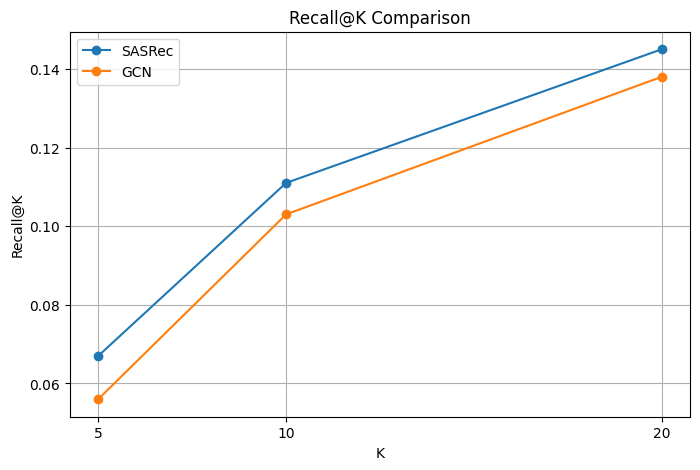

⚠️ Skipping plotting for SASRec+GCN due to missing or incomplete data.


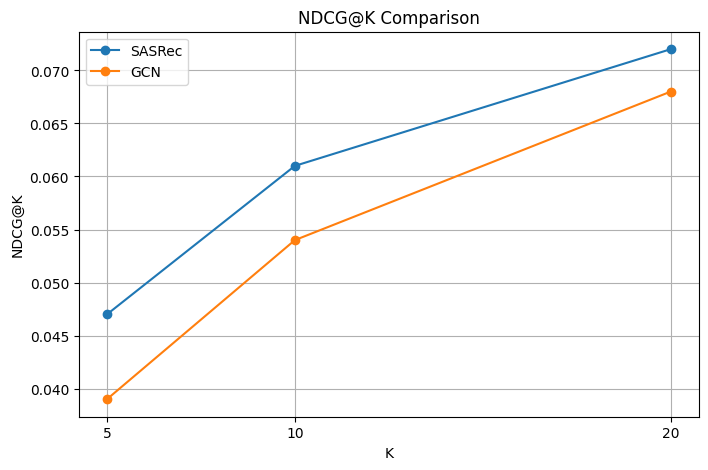

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# ====== 路径配置 ======
DATA_DIR = "/content/drive/MyDrive/lun/data"
METRICS_FILE = os.path.join(DATA_DIR, "metrics.json")  # 假设保存各模型 Recall/NDCG 的 JSON

# ====== 自动读取指标 ======
# JSON 示例结构:
# {
#   "SASRec": {"Recall": [0.067, 0.111, 0.145], "NDCG": [0.047, 0.061, 0.072]},
#   "GCN": {"Recall": [0.056, 0.103, 0.138], "NDCG": [0.039, 0.054, 0.068]},
#   "Fusion": {"Recall": [0.082, 0.128, 0.160], "NDCG": [0.058, 0.072, 0.083]}
# }

if os.path.exists(METRICS_FILE):
    with open(METRICS_FILE, "r") as f:
        metrics_loaded = json.load(f)
    # Use the loaded metrics for "SASRec+GCN" and placeholder data for others
    metrics = {
        "SASRec+GCN": metrics_loaded.get("SASRec+GCN", {}),
        "SASRec": {"Recall":[0.067,0.111,0.145], "NDCG":[0.047,0.061,0.072]}, # Placeholder
        "GCN": {"Recall":[0.056,0.103,0.138], "NDCG":[0.039,0.054,0.068]} # Placeholder
    }
else:
    print("⚠️ 未找到 metrics.json，使用示例数据生成")
    metrics = {
        "SASRec": {"Recall":[0.067,0.111,0.145], "NDCG":[0.047,0.061,0.072]},
        "GCN": {"Recall":[0.056,0.103,0.138], "NDCG":[0.039,0.054,0.068]},
        "Fusion": {"Recall":[0.082,0.128,0.160], "NDCG":[0.058,0.072,0.083]}
    }

# ====== K 值列表 ======
K_LIST = [5,10,20]

# ====== 绘制 Recall@K ======
plt.figure(figsize=(8,5))
for model, data in metrics.items():
    # Ensure data exists and has the expected structure
    if "Recall" in data and len(data["Recall"]) == len(K_LIST):
        plt.plot(K_LIST, data["Recall"], marker='o', label=model)
    else:
        print(f"⚠️ Skipping plotting for {model} due to missing or incomplete data.")

plt.xticks(K_LIST)
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K Comparison")
plt.grid(True)
plt.legend()
plt.show()

# ====== 绘制 NDCG@K ======
plt.figure(figsize=(8,5))
for model, data in metrics.items():
    # Ensure data exists and has the expected structure
    if "NDCG" in data and len(data["NDCG"]) == len(K_LIST):
        plt.plot(K_LIST, data["NDCG"], marker='o', label=model)
    else:
         print(f"⚠️ Skipping plotting for {model} due to missing or incomplete data.")

plt.xticks(K_LIST)
plt.xlabel("K")
plt.ylabel("NDCG@K")
plt.title("NDCG@K Comparison")
plt.grid(True)
plt.legend()
plt.show()